<a href="https://colab.research.google.com/github/vamsivk18/COMP6721_Winter2023_GroupM/blob/Development_bhanu/InceptionV3_2classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
 
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import *
file_name = "/content/drive/MyDrive//dataset_2_classes.zip" 
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [5]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True,drop_last=False,num_workers=0)
    return data_loader,data_set

In [6]:
train_dataset='dataset_2_classes/train/'
train_loader,training_dataset=transform(train_dataset)

In [7]:
validate_dataset='dataset_2_classes/validate/'
validate_loader,validating_dataset=transform(validate_dataset)

In [8]:
test_dataset='dataset_2_classes/test/'
test_loader,testing_dataset=transform(test_dataset)

In [9]:
def set_device():
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

In [10]:
device=set_device()

In [18]:
def get_model():
    model = models.inception_v3(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Linear(128,2))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
    return model.to(device), loss_fn, optimizer

In [13]:
def train_batch(images, labels, model, opt, loss_fn):
    output = model(images)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, labels)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [14]:
@torch.no_grad()
def accuracy(images, labels, model):
    model.eval()
    prediction = model(images)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == labels
    return is_correct.cpu().numpy().tolist()

In [15]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [19]:
model, loss_fn, optimizer = get_model()

In [17]:
n_epochs = 100
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    train_epoch_losses, train_epoch_accuracies = [], []
    for i,data in enumerate(iter(train_loader)):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        batch_loss = train_batch(images, labels, model, optimizer, loss_fn)
        is_correct = accuracy(images, labels, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)*100      
    print('Epoch:',epoch+1,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)

    for i,data in enumerate(iter(validate_loader)):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        val_is_correct = accuracy(images, labels, model)
        validation_loss = val_loss(images, labels, model)    
        val_epoch_accuracy = np.mean(val_is_correct)*100

    print('Epoch:',epoch+1,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


Epoch: 1 
Epoch: 1 Train Loss: 6.875041120634959e+18 Train Accuracy: 77.33333333333333
Epoch: 1 Validation Loss: 0.5856678485870361 Validation Accuracy: 88.88888888888889
Epoch: 2 
Epoch: 2 Train Loss: 14.198974741132636 Train Accuracy: 80.0
Epoch: 2 Validation Loss: 0.675764799118042 Validation Accuracy: 66.66666666666666
Epoch: 3 
Epoch: 3 Train Loss: 0.6579315599642301 Train Accuracy: 80.0
Epoch: 3 Validation Loss: 0.6431423425674438 Validation Accuracy: 88.88888888888889
Epoch: 4 
Epoch: 4 Train Loss: 0.6526424382862291 Train Accuracy: 80.0
Epoch: 4 Validation Loss: 0.6445143222808838 Validation Accuracy: 83.33333333333334
Epoch: 5 
Epoch: 5 Train Loss: 0.6471405531230726 Train Accuracy: 80.0
Epoch: 5 Validation Loss: 0.648508608341217 Validation Accuracy: 77.77777777777779
Epoch: 6 
Epoch: 6 Train Loss: 0.642626847091474 Train Accuracy: 80.0
Epoch: 6 Validation Loss: 0.6222763061523438 Validation Accuracy: 88.88888888888889
Epoch: 7 
Epoch: 7 Train Loss: 0.6372635960578918 Train A

In [20]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted_correct= accuracy(images, labels, model)
    epoch_accuracy = np.mean(val_is_correct)*100
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [21]:
   test_acc = evaluate_model(model,test_loader)

Testing Data: Epoch Accuracy: 72.222


In [22]:
dict = {'Training': train_accuracies, 'Validation': val_accuracies} 
dictLoss = {'Training': train_losses,'Validation': val_losses}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)

In [24]:
import matplotlib.pyplot as plt

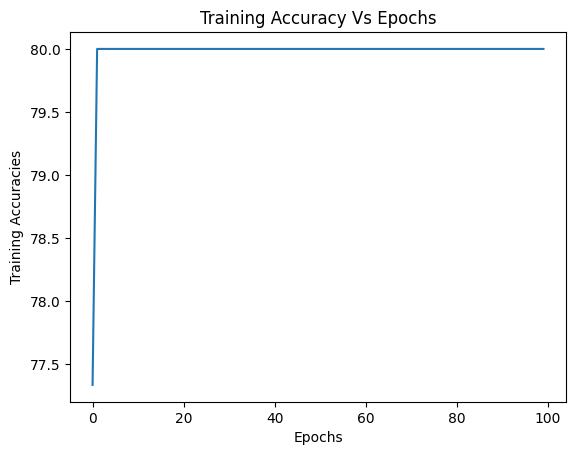

In [25]:
plt.plot(range(n_epochs),train_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

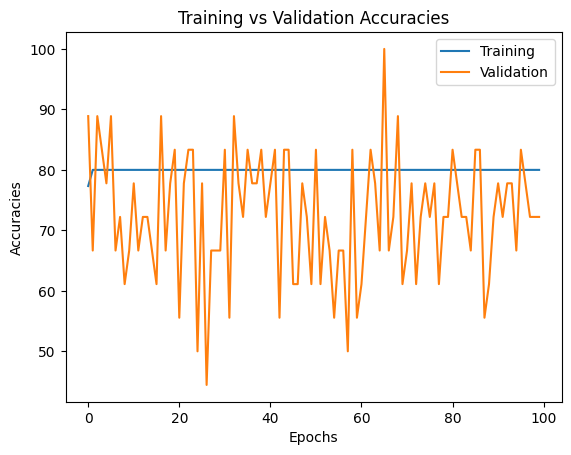

In [26]:
plt.plot(range(n_epochs),train_accuracies, label="Training")
plt.plot(range(n_epochs),val_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

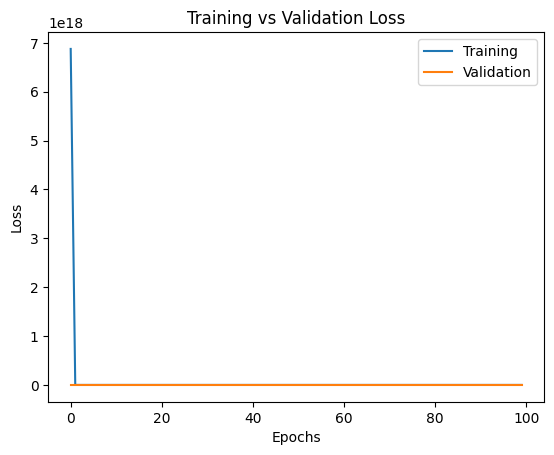

In [27]:
plt.plot(range(n_epochs),train_losses, label="Training")
plt.plot(range(n_epochs),val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [29]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

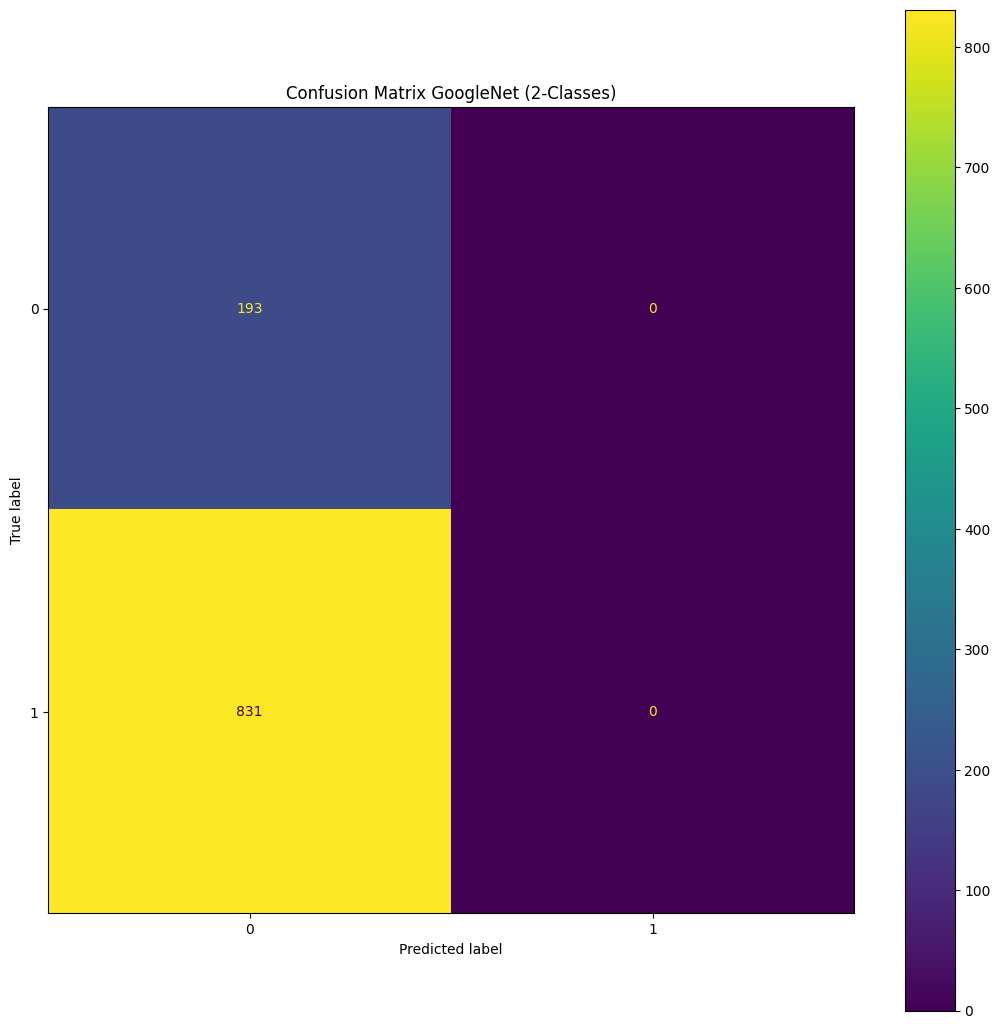

In [30]:
classes = (0,1)
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix GoogleNet (2-Classes)")
disp.plot(ax=ax)
plt.show()

In [31]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.09
Precision Micro:0.19
Recall Macro:0.50
Recall Micro:0.19
F1-Score Macro:0.16
F1-Score Micro:0.19


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
